In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config IPCompleter.greedy=True

## Создание csv с данными о типах блюд в чеках по дням

#### Загрузим тренировочные данные

In [2]:
train = pd.read_csv('data/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919985 entries, 0 to 919984
Data columns (total 6 columns):
chknum       919985 non-null object
person_id    919985 non-null int64
month        919985 non-null int64
day          919985 non-null int64
good         919985 non-null object
good_id      919985 non-null int64
dtypes: int64(4), object(2)
memory usage: 42.1+ MB


In [3]:
train.head()

chknum  person_id  month  day                                   good  \
0    id0          1      1   17    Грибовница со взбитыми яйцами 250гр   
1    id0          1      1   17                   Булочка с сыром 60гр   
2    id0          1      1   17                          Салат бар 1кг   
3    id0          1      1   17  С-т из огур/помидор/перец/масло 120гр   
4    id1        626      1   17              Индейка/грибы/сыр 80/20гр   

   good_id  
0       12  
1       13  
2        8  
3      124  
4      181

#### Меню

Загрузим наше меню

In [4]:
menu_file = pd.read_csv('data/menu_tagged.csv')

In [5]:
menu_file.columns

Index(['good_id', 'good', 'first_course', 'main_course', 'drink', 'bakery',
       'dessert', 'snacks', 'salad', 'meat&fish', 'fried', 'sweet', 'salty',
       'spicy', 'sour', 'lenten', 'meat', 'seafoods', 'pepper', 'mushrooms',
       'vegetables', 'fruits', 'milk', 'croups', 'eggs', 'pasta', 'flour',
       'onion_or_garlic', 'other'],
      dtype='object')

Сделаем доступным обращение к данным о типах блюда по его id

In [6]:
TAG_CNT = 27
menu = {}
for row in menu_file.values:
    menu[int(row[0])] = list(map(int, row[2:]))
print(menu[1])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


Можно представить наши данные о людях в виде такой вложенной структуры (можно ввести классы Date, Person, Check)

In [7]:
# chknum person_id month day good good_id
# dates: dict of dicts of checks and persons with lists of goods
dates = {}
for row in train.values:
    chknum, person_id, month, day, good, good_id = row
    current_date = (month, day)
    dates.setdefault(current_date, dict()).setdefault(chknum, (person_id, list()))[1].append((good, good_id))
# dates[(month, day)]['chk_id'][1] - list of goods
# dates[(month, day)]['chk_id'][0] - person_id
print(dates[(1, 17)]['id0'][1])

[('Грибовница со взбитыми яйцами 250гр', 12), ('Булочка с сыром 60гр', 13), ('Салат бар 1кг', 8), ('С-т из огур/помидор/перец/масло 120гр', 124)]


Далее можно собрать статистику во вложенную структуру

In [8]:
# stats: dict of lists  representing (person, types_counts_list) by date
stats = {}
for date, date_val in dates.items():
    onday = []
    for chk in date_val.values():
        buy = (chk[0], [0] * TAG_CNT)
        for good in chk[1]:
            for i in range(TAG_CNT):
                buy[1][i] += menu[good[1]][i]
        onday.append(buy)
    stats[date] = onday

# print(stats[(1, 17)])

Или же в виде таблицы

In [9]:
columns = ['month', 'day', 'chknum', 'person_id', 'first_course', 'main_course', 'drink', 'bakery', 'dessert', 'snacks', 'salad', 'meat&fish', 'fried', 'sweet', 'salty',
       'spicy', 'sour', 'lenten', 'meat', 'seafoods', 'pepper', 'mushrooms',
       'vegetables', 'fruits', 'milk', 'croups', 'eggs', 'pasta', 'flour',
       'onion_or_garlic', 'other']

data_for_pd = []
for date, date_val in dates.items():
    for chknum, chk in date_val.items():
        buy = [0] * TAG_CNT
        for good in chk[1]:
            for i in range(TAG_CNT):
                buy[i] += menu[good[1]][i]
        data_for_pd.append([date[0], date[1], chknum, chk[0], *buy])

df = pd.DataFrame(data_for_pd, columns=columns)
df.head()

month  day chknum  person_id  first_course  main_course  drink  bakery  \
0      1   17    id0          1             1            0      0       1   
1      1   17    id1        626             0            1      1       0   
2      1   17    id2       1438             0            1      1       0   
3      1   17    id3        190             1            1      1       0   
4      1   17    id4        139             0            1      1       0   

   dessert  snacks  ...  mushrooms  vegetables  fruits  milk  croups  eggs  \
0        0       0  ...          1           2       0     1       0     1   
1        0       0  ...          1           3       1     1       0     0   
2        0       0  ...          0           4       1     0       0     0   
3        0       3  ...          1           3       1     0       0     0   
4        0       0  ...          0           4       1     0       0     0   

   pasta  flour  onion_or_garlic  other  
0      0      1                0      0  
1      0      0                0      0  
2      1      0                0      0  
3      0      3                0      0  
4      0      0                0      0  

[5 rows x 31 columns]

In [19]:
df.to_csv('stats/goods_types_by_day_and_chk.csv', index=False)

## Анализ

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
stats_df = pd.read_csv('stats/goods_types_by_day_and_chk.csv', index_col='chknum')
stats_df.head()

month  day  person_id  first_course  main_course  drink  bakery  \
chknum                                                                    
id0         1   17          1             1            0      0       1   
id1         1   17        626             0            1      1       0   
id2         1   17       1438             0            1      1       0   
id3         1   17        190             1            1      1       0   
id4         1   17        139             0            1      1       0   

        dessert  snacks  salad  ...  mushrooms  vegetables  fruits  milk  \
chknum                          ...                                        
id0           0       0      2  ...          1           2       0     1   
id1           0       0      2  ...          1           3       1     1   
id2           0       0      2  ...          0           4       1     0   
id3           0       3      1  ...          1           3       1     0   
id4           0       0      1  ...          0           4       1     0   

        croups  eggs  pasta  flour  onion_or_garlic  other  
chknum                                                      
id0          0     1      0      1                0      0  
id1          0     0      0      0                0      0  
id2          0     0      1      0                0      0  
id3          0     0      0      3                0      0  
id4          0     0      0      0                0      0  

[5 rows x 30 columns]

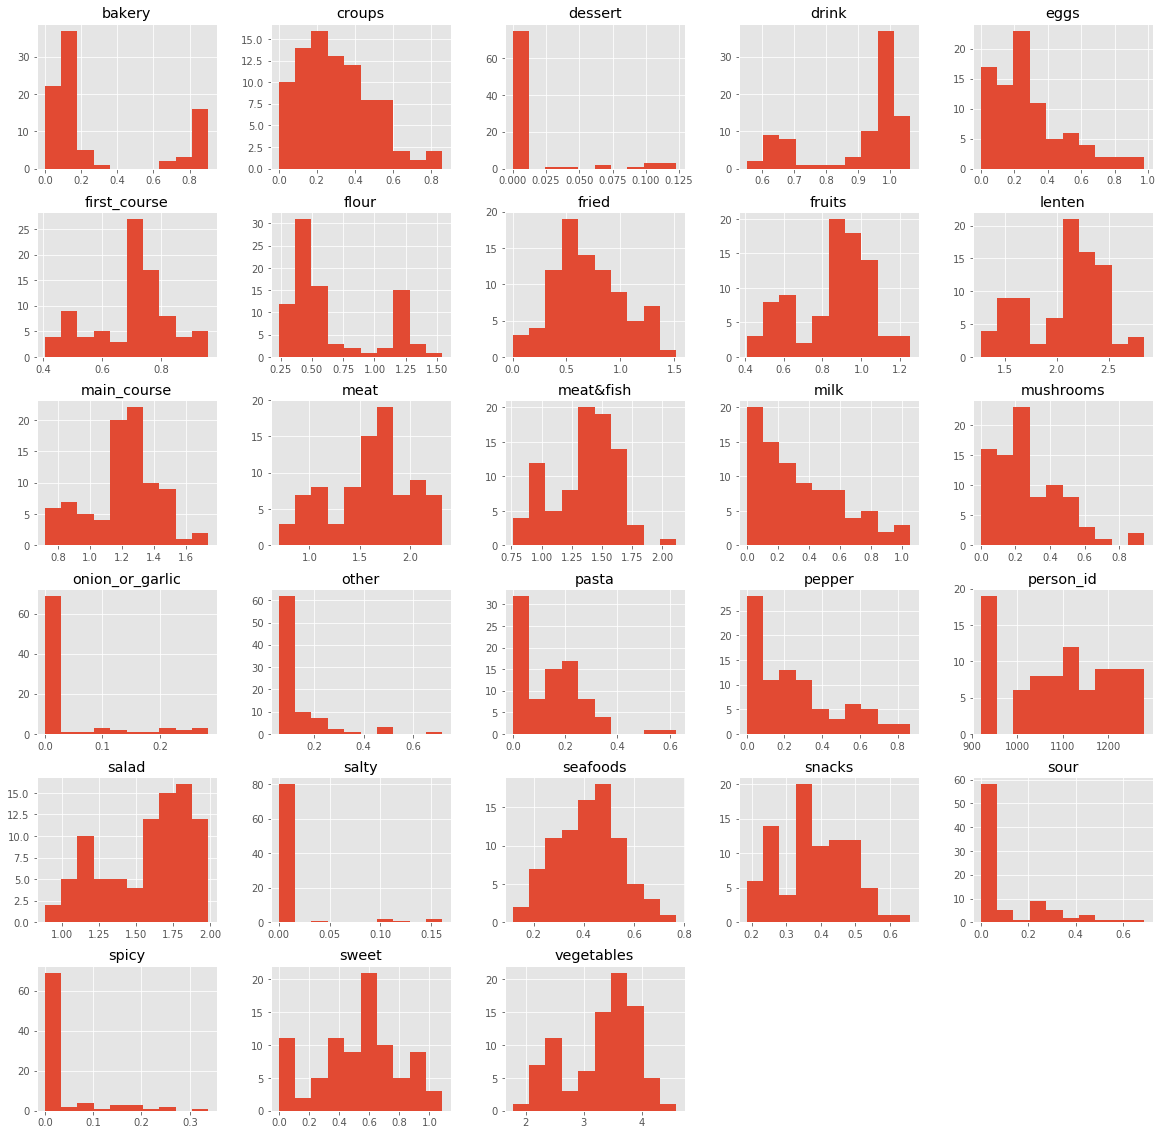

In [3]:
stats_df.groupby(['month', 'day']).mean().hist(figsize=(20, 20));

In [4]:
grouped = stats_df.iloc[:, 2:].groupby(['person_id']).mean()
grouped.describe()

first_course  main_course        drink       bakery      dessert  \
count   2604.000000  2604.000000  2604.000000  2604.000000  2604.000000   
mean       0.692152     1.211371     0.888594     0.249746     0.011127   
std        0.296207     0.464719     0.497984     0.275655     0.025374   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.518669     0.966245     0.739470     0.044944     0.000000   
50%        0.792893     1.107625     0.876818     0.173913     0.000000   
75%        0.904887     1.363636     1.000000     0.364541     0.013514   
max        1.846154     4.000000     4.000000     3.333333     0.500000   

            snacks        salad    meat&fish        fried        sweet  ...  \
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000  ...   
mean      0.382647     1.546392     1.318800     0.680436     0.507519  ...   
std       0.506683     0.542394     0.488733     0.284113     0.282767  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.036585     1.169913     1.000000     0.505989     0.333333  ...   
50%       0.142081     1.530060     1.217891     0.648250     0.530306  ...   
75%       0.545719     1.875000     1.533333     0.835329     0.656329  ...   
max       3.000000     4.642857     4.727273     3.000000     2.000000  ...   

         mushrooms   vegetables       fruits         milk       croups  \
count  2604.000000  2604.000000  2604.000000  2604.000000  2604.000000   
mean      0.274528     3.288346     0.837780     0.324271     0.299785   
std       0.203745     0.799215     0.376741     0.205413     0.190495   
min       0.000000     0.600000     0.000000     0.000000     0.000000   
25%       0.142857     2.785069     0.732558     0.200000     0.178571   
50%       0.243746     3.224604     0.876347     0.305556     0.275000   
75%       0.372093     3.750000     1.000000     0.422117     0.392933   
max       2.000000     8.000000     3.000000     3.000000     3.000000   

              eggs        pasta        flour  onion_or_garlic        other  
count  2604.000000  2604.000000  2604.000000      2604.000000  2604.000000  
mean      0.272696     0.131683     0.629181         0.035934     0.132150  
std       0.174667     0.112455     0.585367         0.057136     0.332088  
min       0.000000     0.000000     0.000000         0.000000     0.000000  
25%       0.153846     0.057692     0.188179         0.000000     0.021739  
50%       0.256254     0.118421     0.468750         0.023256     0.052632  
75%       0.368421     0.185281     0.902733         0.048544     0.098799  
max       2.000000     1.032787     4.000000         1.000000     3.055556  

[8 rows x 27 columns]

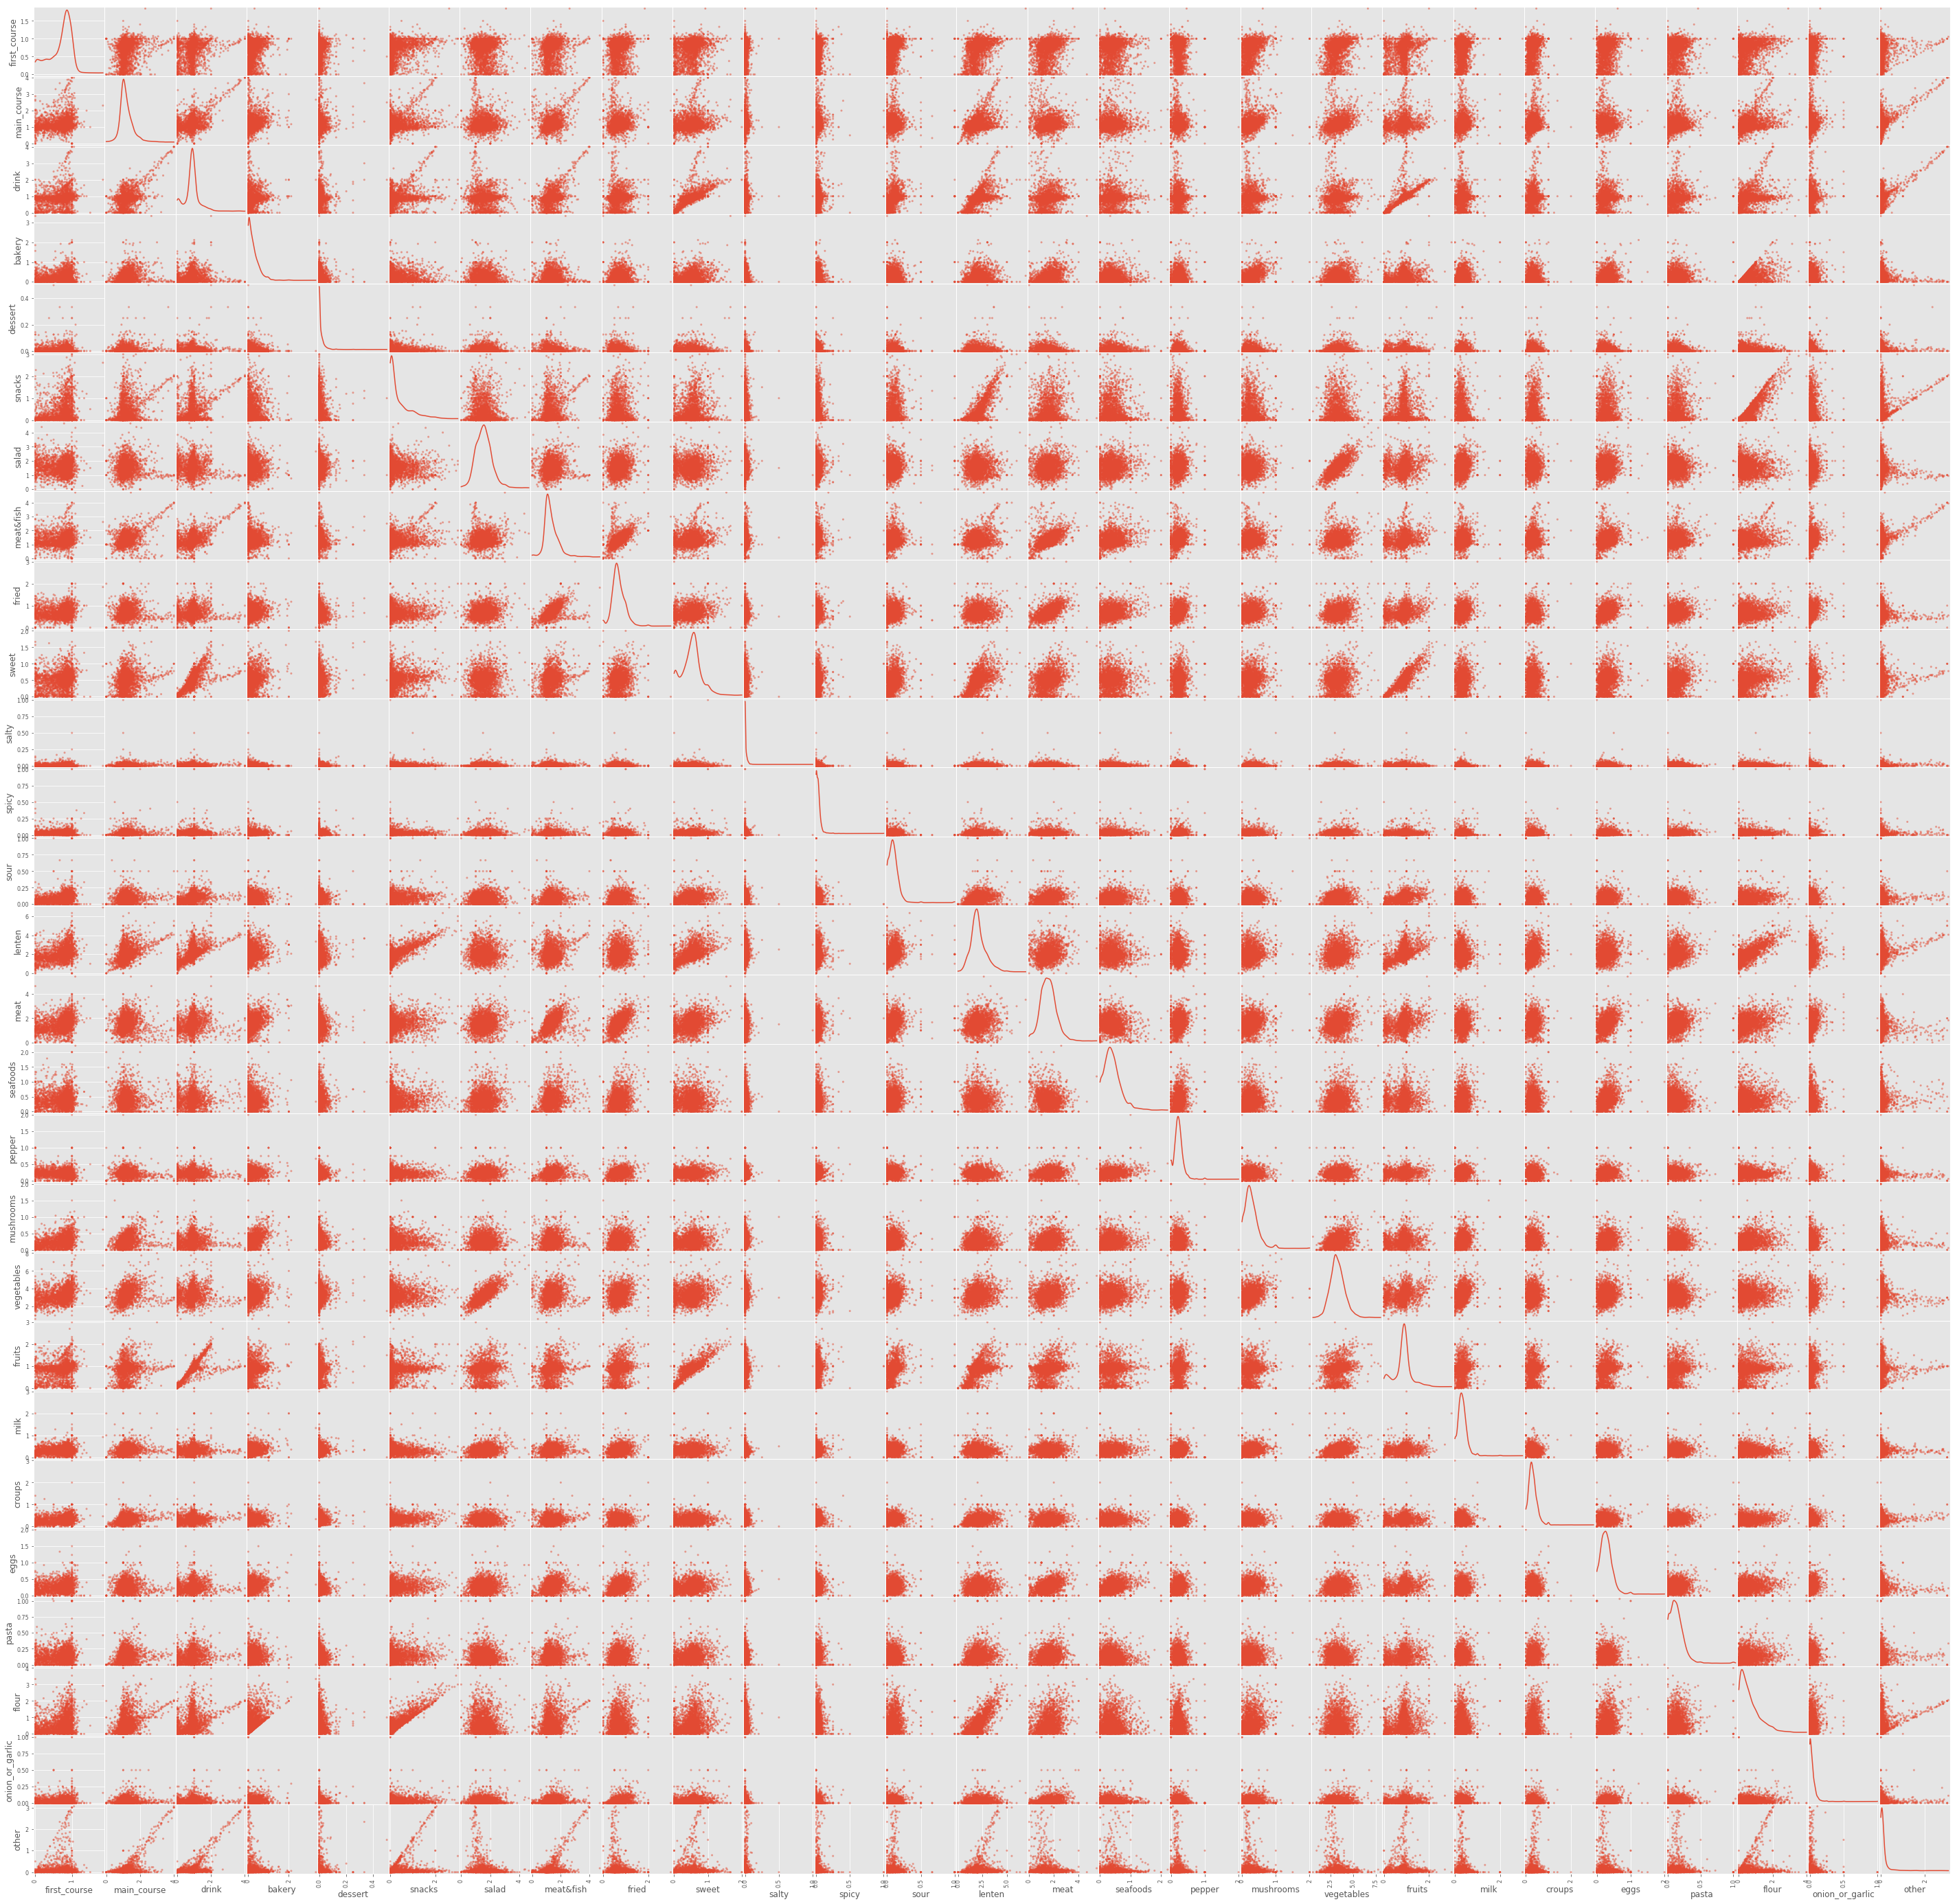

In [5]:
from pandas.plotting import scatter_matrix
grouped = stats_df.iloc[:, 2:].groupby(['person_id']).mean()
scatter_matrix(grouped, diagonal='kde', figsize=(50, 50));

In [10]:
stats_df.shape

(159229, 30)

In [15]:
stats_df.iloc[:159229 // 100 * 70, 1:3].groupby(['person_id']).count().describe()

day
count  2385.000000
mean     46.725367
std      23.246735
min       1.000000
25%      29.000000
50%      55.000000
75%      64.000000
max      89.000000